In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

pd.set_option("display.max_columns", 1000)

/home/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [2]:
# links
# https://drive.google.com/drive/folders/18dV790r11hHKIwpbyDBaxMV4XbhBFQde?usp=drive_link

In [3]:
n = pypsa.Network()

In [4]:
# entsoe network file
entsoe_nc = pypsa.Network("elec-entsoe.nc")

INFO:pypsa.io:Imported network elec-entsoe.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


In [5]:
# load entsoe line.csv with pandas dataframe
entsoe_ref_csv = pd.read_csv("entsoe_lines_ref.csv", delimiter=",", quotechar="'")

# apply well known text(wkt) to format the geometry column properly
entsoe_ref_csv["geometry"] = entsoe_ref_csv.geometry.apply(wkt.loads)

# load the data into a geopandas dataframe and format it using a compatible crs
entsoe_csv = gpd.GeoDataFrame(entsoe_ref_csv, geometry="geometry", crs="EPSG:3035")

# convert voltage from kV to V
entsoe_csv["voltage"] = entsoe_csv.voltage * 1000

In [6]:
# networks
de_base_nc_file = "osm_data_validation_AT_MK_IT_DE/networks/DE/base.nc"
it_base_nc_file = "osm_data_validation_AT_MK_IT_DE/networks/IT/base.nc"

# resource files
de_base_csv_file = "osm_data_validation_AT_MK_IT_DE/resources/DE/base_network/all_lines_build_network.csv"
it_base_csv_file = "osm_data_validation_AT_MK_IT_DE/resources/IT/base_network/all_lines_build_network.csv"

de_country_shape_file = "osm_data_validation_AT_MK_IT_DE/resources/DE/shapes/country_shapes.geojson"
it_country_shape_file = "osm_data_validation_AT_MK_IT_DE/resources/IT/shapes/country_shapes.geojson"

In [7]:
# loading network files with pypsa
de_base_nc = pypsa.Network(de_base_nc_file)
it_base_nc = pypsa.Network(it_base_nc_file)

de_base_csv = pd.read_csv(de_base_csv_file)
de_base_csv["geometry"] = de_base_csv.geometry.apply(wkt.loads)
de_base_csv = gpd.GeoDataFrame(de_base_csv, geometry="geometry", crs="EPSG:4326")
de_base_csv["converted_length"] = de_base_csv.to_crs("EPSG:3035").length

it_base_csv = pd.read_csv(it_base_csv_file)
it_base_csv["geometry"] = it_base_csv.geometry.apply(wkt.loads)
it_base_csv = gpd.GeoDataFrame(it_base_csv, geometry="geometry", crs="EPSG:4326")
it_base_csv["converted_length"] = it_base_csv.to_crs("EPSG:3035").length

INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers
INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers


In [8]:
de_country_shape = gpd.read_file(de_country_shape_file)
it_country_shape = gpd.read_file(it_country_shape_file)

In [9]:
def if_country_in_entsoe(country_df: gpd.GeoDataFrame, base_data: gpd.GeoDataFrame) -> pd.Series:
    """
    Function checks if country_df is present in enstoe data
    """
    x = base_data["geometry"].apply(lambda row: row.within(country_df["geometry"][0]))
    return x

def get_i_nom_by_voltage(voltage_value: int, network: pypsa.Network) -> int:
    """
    func returns the current corresponding to the voltage_value using line_types in pypsa network
    """

    voltage_dict = {
        220: "Al/St 240/40 2-bundle 220.0",
        300: "Al/St 240/40 3-bundle 300.0",
        380: "Al/St 240/40 4-bundle 380.0",
    }

    line_type = max(voltage_dict.values())

    for idx in sorted(voltage_dict.keys()):
        if (voltage_value) <= idx:
            line_type = voltage_dict.get(idx)
            break
        
    return network.line_types.loc[line_type, "i_nom"] # kA


def calculate_s_nom(df: gpd.GeoDataFrame, network: pypsa.Network) -> gpd.GeoDataFrame:
    """
    Func calc s_nom using the s_nom defined formula from pypsa earth
    s_nom = sqrt(3) * v_nom(kV) * circuits * i_nom(kA)
    """    
    
    df['voltage_kV'] = df['voltage'] / 1e3 # divide voltage by 1e3 to convert it to kV
    df["s_nom"] = (df["voltage"].apply(lambda row: get_i_nom_by_voltage(row, n))) \
                    * df["voltage_kV"] \
                    * np.sqrt(3) * df["circuits"]

    # s_nom units in ???

    return df
    

In [10]:
# Calculate 's_nom' values
de_base_csv_s_nom = calculate_s_nom(de_base_csv, network=n)
it_base_csv_s_nom = calculate_s_nom(it_base_csv, network=n)

In [11]:
sum_de_base_csv_snom = de_base_csv_s_nom.s_nom.sum()
sum_de_base_nc_snom = de_base_nc.lines.s_nom.sum()

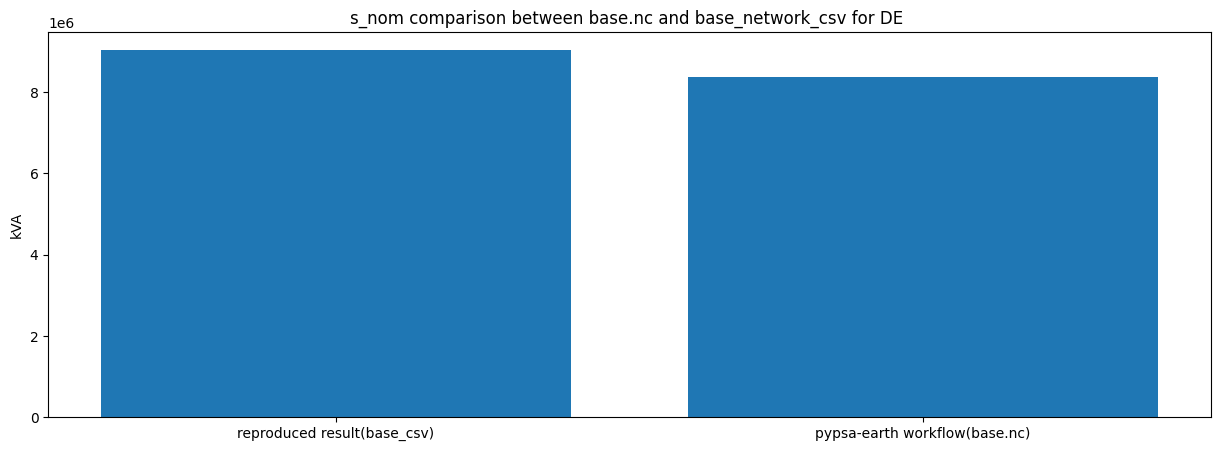

In [12]:
plt.figure(figsize=(15,5))
plt.bar(["reproduced result(base_csv)", "pypsa-earth workflow(base.nc)"], [sum_de_base_csv_snom, sum_de_base_nc_snom])
plt.title("s_nom comparison between base.nc and base_network_csv for DE ")
plt.ylabel("kVA")
# plt.legend()
plt.show()


In [13]:
entsoe_csv["if_de"] = if_country_in_entsoe(de_country_shape, entsoe_csv)
entsoe_csv["if_it"] = if_country_in_entsoe(it_country_shape, entsoe_csv)

In [14]:
entsoe_nc_country = entsoe_nc.lines \
        .merge(entsoe_nc.buses['country'] \
        .reset_index(), 
            how='left', 
            left_on='bus0', 
            right_on='Bus')

In [15]:
entsoe_nc_de = entsoe_nc_country[entsoe_nc_country.country == "DE"]
entsoe_nc_it = entsoe_nc_country[entsoe_nc_country.country == "IT"]

In [19]:
sum_de_base_csv_snom_200kv = de_base_csv_s_nom[de_base_csv_s_nom.voltage > 200000].s_nom.sum()

entsoe_s_nom = calculate_s_nom(entsoe_csv, n)
sum_de_entsoe_snom = entsoe_s_nom[entsoe_s_nom.if_de == True].s_nom.sum()

sum_entose_nc_de_snom = entsoe_nc_de.s_nom.sum()

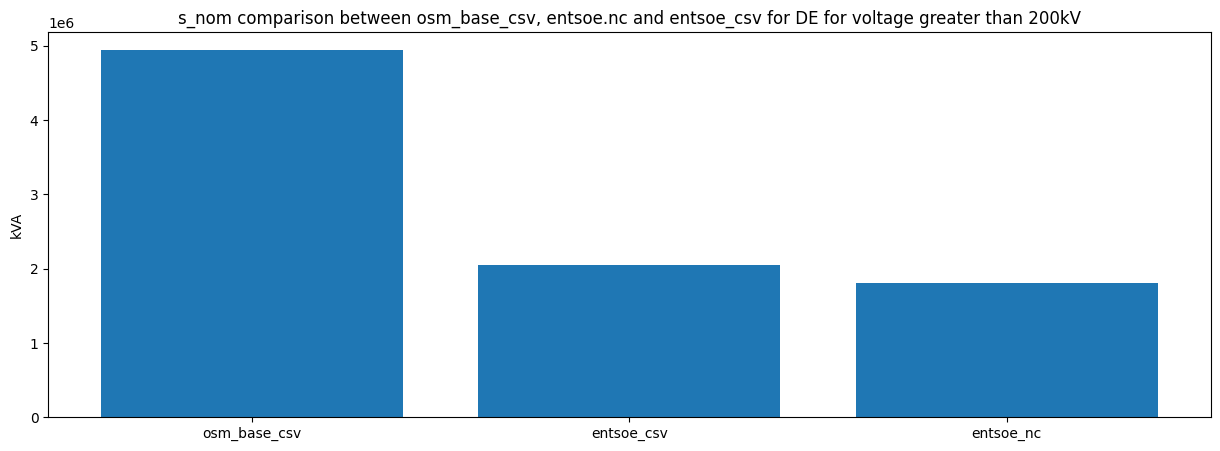

In [20]:
plt.figure(figsize=(15,5))
plt.bar(["osm_base_csv", "entsoe_csv", "entsoe_nc"], [sum_de_base_csv_snom_200kv, sum_de_entsoe_snom, sum_entose_nc_de_snom])
plt.title("s_nom comparison between osm_base_csv, entsoe.nc and entsoe_csv for DE for voltage greater than 200kV")
plt.ylabel("kVA")
plt.show()

In [21]:
de_base_csv_s_nom_220kv = de_base_csv_s_nom[de_base_csv_s_nom.voltage > 200000]
twkm_de_base_csv = (de_base_csv_s_nom_220kv.s_nom * de_base_csv_s_nom_220kv.converted_length).sum() / 1e3

In [22]:
de_entsoe_snom_csv = entsoe_s_nom[entsoe_s_nom.if_de == True]
twkm_de_entsoe_csv = ((de_entsoe_snom_csv["length"] / 1e3) * (de_entsoe_snom_csv["s_nom"])).sum()

In [23]:
twkm_de_entsoe_nc = (entsoe_nc_de["length"] * entsoe_nc_de["s_nom"]).sum()

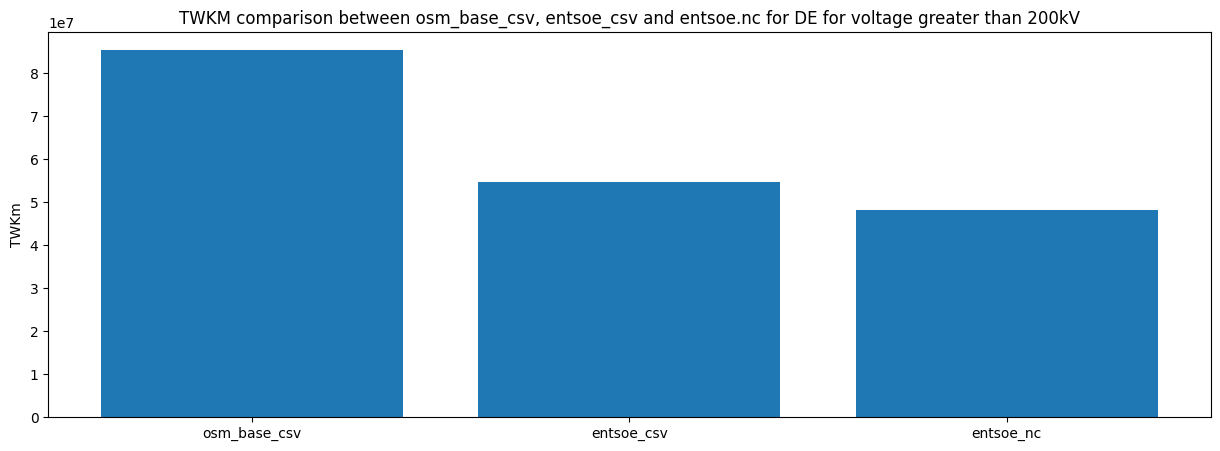

In [24]:
plt.figure(figsize=(15,5))
plt.bar(["osm_base_csv", "entsoe_csv", "entsoe_nc"], [twkm_de_base_csv, twkm_de_entsoe_csv, twkm_de_entsoe_nc])
plt.title("TWKM comparison between osm_base_csv, entsoe_csv and entsoe.nc for DE for voltage greater than 200kV")
plt.ylabel("TWKm")
plt.show()